[![ Click here to deploy.](https://uohmivykqgnnbiouffke.supabase.co/storage/v1/object/public/landingpage/brevdeploynavy.svg)](https://console.brev.dev/launchable/deploy/now?launchableID=env-2rgiXa7D63Aq0bmKElJq2HpAY2x)

NOTE: it takes about 10 minutes to deploy this notebook as a Launchable. As of this writing, we are working on a free tier so a credit card may be required. You can reach out to your NVIDIA rep for credits."

# Building Generative Models for Continuous Data via Continuous Interpolants

In [1]:
import math
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import torch

from sklearn.datasets import make_moons

# Task Setup

To demonstrate how Conditional Flow Matching works we use sklearn to sample from and create custom 2D distriubtions.

To start we define our "dataloader" so to speak. This is the '''sample_moons''' function.

Next we define a custom PriorDistribution to enable the conversion of 8 equidistance gaussians to the moon distribution above.



In [2]:
def sample_moons(n, normalize = False):
    x1, _ = make_moons(n_samples=n, noise=0.08)
    x1 = torch.Tensor(x1)
    x1 =  x1 * 3 - 1
    if normalize:
        x1 = (x1 - x1.mean(0))/x1.std(0) * 2
    return x1

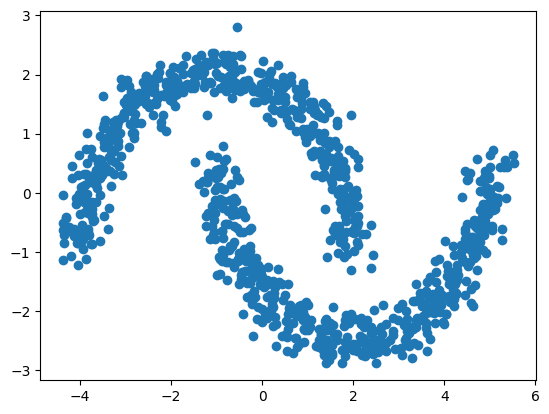

In [3]:
x1 = sample_moons(1000)
plt.scatter(x1[:, 0], x1[:, 1])

# Model Creation
Here we define a simple 4 layer MLP and define our optimizer

In [4]:
import math
from typing import List

import torch
import torch.nn as nn
import torch.nn.functional as F

class Network(nn.Module):
    def __init__(
        self, dim_in: int, dim_out: int, dim_hids: List[int],
    ):
        super().__init__()
        self.layers = nn.ModuleList([
            TimeLinear(dim_in, dim_hids[0]),
            *[TimeLinear(dim_hids[i-1], dim_hids[i]) for i in range(1, len(dim_hids))],
            TimeLinear(dim_hids[-1], dim_out)
        ])

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        for i, layer in enumerate(self.layers):
            x = layer(x, t)
            if i < len(self.layers) - 1:
                x = F.relu(x)
        return x
        
class TimeLinear(nn.Module):
    def __init__(self, dim_in: int, dim_out: int):
        super().__init__()
        self.dim_in = dim_in
        self.dim_out = dim_out

        self.time_embedding = TimeEmbedding(dim_out)
        self.fc = nn.Linear(dim_in, dim_out)

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        x = self.fc(x)
        alpha = self.time_embedding(t).view(-1, self.dim_out)
        return alpha * x
        
class TimeEmbedding(nn.Module):
    # https://github.com/openai/glide-text2im/blob/main/glide_text2im/nn.py
    def __init__(self, hidden_size, frequency_embedding_size=256):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(frequency_embedding_size, hidden_size, bias=True),
            nn.SiLU(),
            nn.Linear(hidden_size, hidden_size, bias=True),
        )
        self.frequency_embedding_size = frequency_embedding_size

    @staticmethod
    def timestep_embedding(t, dim, max_period=10000):
        """
        Create sinusoidal timestep embeddings.
        :param t: a 1-D Tensor of N indices, one per batch element.
                          These may be fractional.
        :param dim: the dimension of the output.
        :param max_period: controls the minimum frequency of the embeddings.
        :return: an (N, D) Tensor of positional embeddings.
        """
        # https://github.com/openai/glide-text2im/blob/main/glide_text2im/nn.py
        half = dim // 2
        freqs = torch.exp(
            -math.log(max_period)
            * torch.arange(start=0, end=half, dtype=torch.float32)
            / half
        ).to(device=t.device)
        args = t[:, None].float() * freqs[None]
        embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
        if dim % 2:
            embedding = torch.cat(
                [embedding, torch.zeros_like(embedding[:, :1])], dim=-1
            )
        return embedding

    def forward(self, t: torch.Tensor):
        if t.ndim == 0:
            t = t.unsqueeze(-1)
        t_freq = self.timestep_embedding(t, self.frequency_embedding_size)
        t_emb = self.mlp(t_freq)
        return t_emb

# DDPM Interpolant
### note DDPM must be used with a Gaussian Prior.

In [5]:
from bionemo.moco.distributions.time import UniformTimeDistribution
from bionemo.moco.interpolants import DDPM
from bionemo.moco.schedules.noise.discrete_noise_schedules import DiscreteCosineNoiseSchedule, DiscreteLinearNoiseSchedule
from bionemo.moco.schedules.inference_time_schedules import DiscreteLinearInferenceSchedule
from bionemo.moco.distributions.prior import GaussianPrior
DEVICE = "cuda:0"
uniform_time = UniformTimeDistribution(discrete_time=True, nsteps = 1000)
simple_prior = GaussianPrior()
ddpm = DDPM(time_distribution=uniform_time, 
                            prior_distribution=simple_prior,
                            prediction_type = "noise",
                            noise_schedule = DiscreteLinearNoiseSchedule(nsteps = 1000),
                            device=DEVICE)

## Train the Model

In [6]:
# Place both the model and the interpolant on the same device
dim = 2
hidden_size = 128
num_hiddens = 3
batch_size = 256
model = Network(dim_in=dim, 
                dim_out=dim, 
                dim_hids=[hidden_size]*num_hiddens)
optimizer = torch.optim.Adam(model.parameters(), lr = 1.e-3)
DEVICE = "cuda"
model = model.to(DEVICE)
ddpm = ddpm.to_device(DEVICE)
for k in range(20000):
    optimizer.zero_grad()
    shape = (batch_size, dim)
    x0 = ddpm.sample_prior(shape).to(DEVICE)
    x1 = sample_moons(batch_size).to(DEVICE)

    t = ddpm.sample_time(batch_size)
    xt = ddpm.interpolate(x1, t, x0)

    eps = model(xt, t)
    loss = ddpm.loss(eps, x0, t).mean()

    loss.backward()
    optimizer.step()

    if (k + 1) % 1000 == 0:
        print(f"{k+1}: loss {loss.item():0.3f}") 

1000: loss 0.426
2000: loss 0.299
3000: loss 0.333
4000: loss 0.362
5000: loss 0.300
6000: loss 0.387
7000: loss 0.334
8000: loss 0.396
9000: loss 0.313
10000: loss 0.311
11000: loss 0.413
12000: loss 0.342
13000: loss 0.367
14000: loss 0.307
15000: loss 0.347
16000: loss 0.304
17000: loss 0.370
18000: loss 0.401
19000: loss 0.421
20000: loss 0.334


## Let's vizualize what the interpolation looks like during training for different times

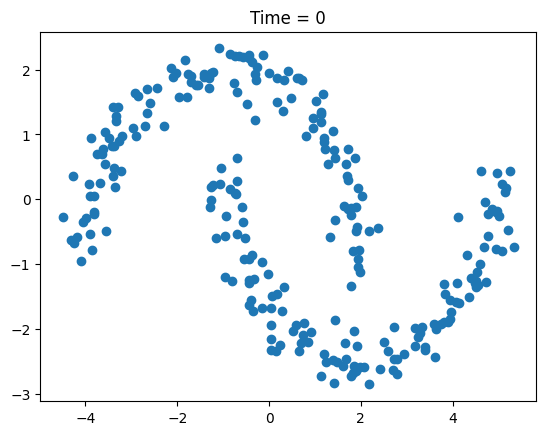

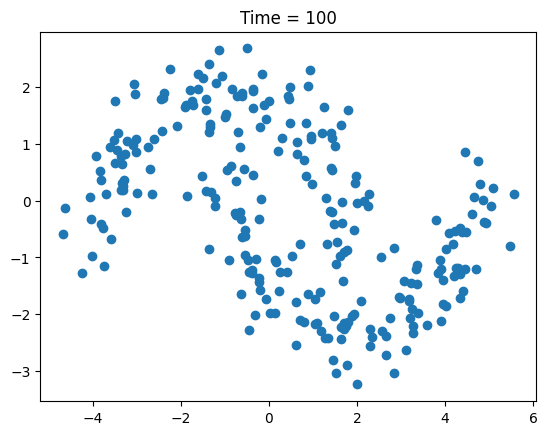

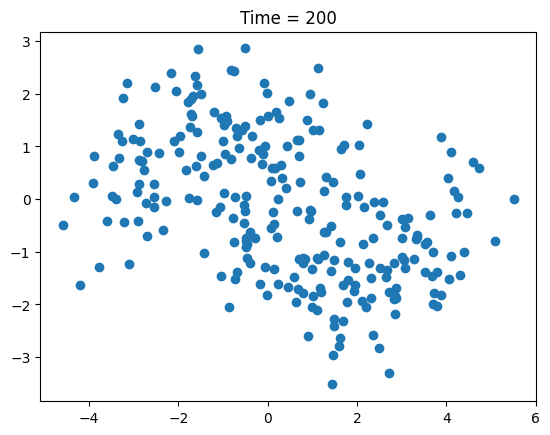

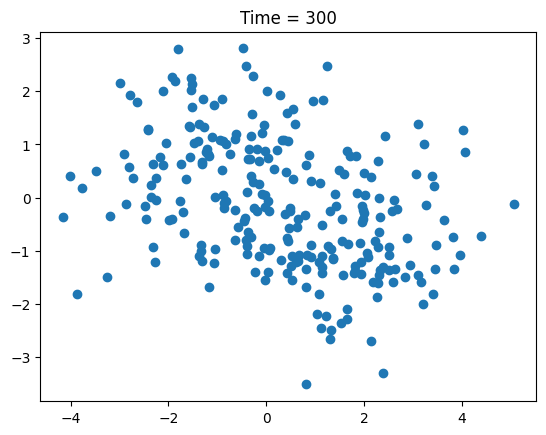

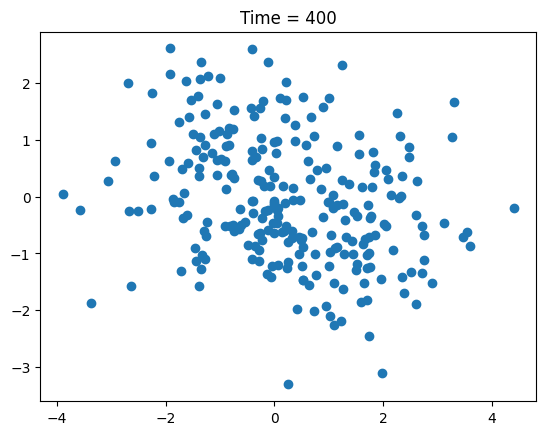

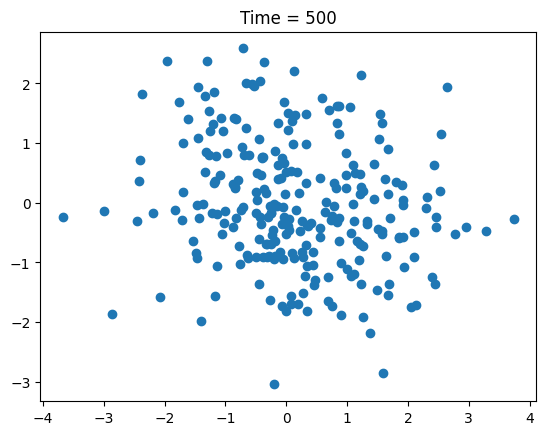

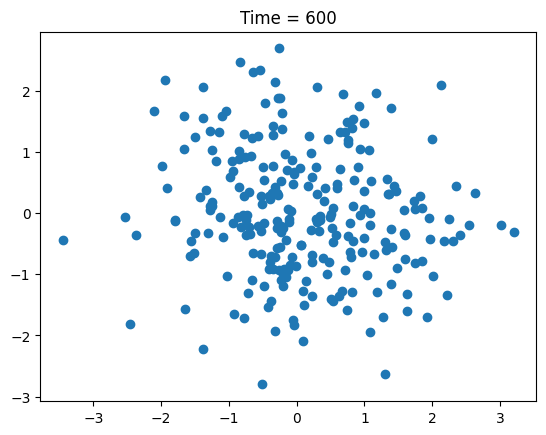

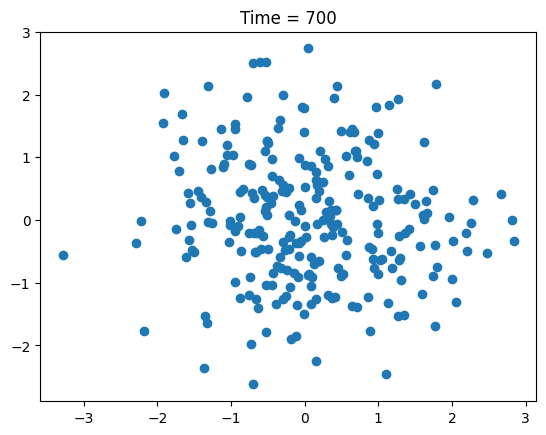

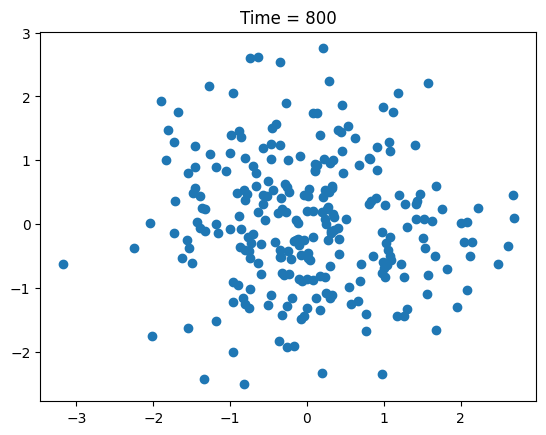

In [7]:
x0 = ddpm.sample_prior(shape).to(DEVICE)
x1 = sample_moons(batch_size).to(DEVICE)
for t in range(0, 900, 100):
    tt = ddpm.sample_time(batch_size)*0 + t
    out = ddpm.interpolate(x1, tt, x0)
    plt.scatter(out[:, 0].cpu().detach(), out[:, 1].cpu().detach())
    plt.title(f"Time = {t}")
    plt.show()

## Create the inference time schedule and sample from the model

In [13]:
with torch.no_grad():
    inf_size = 1024
    schedule = DiscreteLinearInferenceSchedule(nsteps = 1000, direction = "diffusion").generate_schedule(device= DEVICE)                                     
    sample = ddpm.sample_prior((inf_size, 2)).to(DEVICE) # Start with noise
    trajectory = [sample.cpu()]
    for t in schedule:
        full_t  = torch.full((inf_size,), t).to(DEVICE)
        eps_hat = model(sample, full_t)
        sample = ddpm.step_noise(eps_hat, full_t, sample)
        trajectory.append(sample.cpu()) # save the trajectory for plotting purposes


/home/dreidenbach/mambaforge/envs/moco_bionemo/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


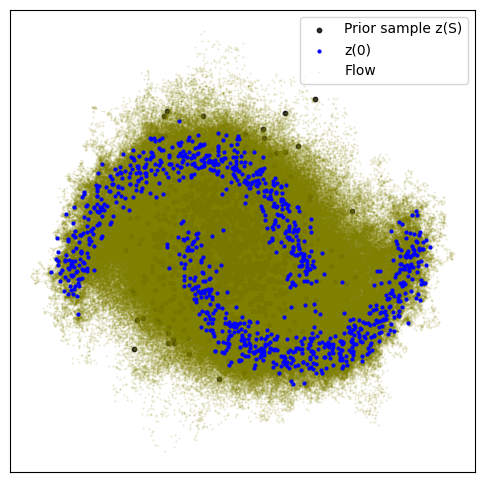

In [14]:
import matplotlib.pyplot as plt
traj = torch.stack(trajectory).numpy()
plot_limit = 1024

plt.figure(figsize=(6, 6))

# Plot the first time point in black
plt.scatter(traj[0, :plot_limit, 0], traj[0, :plot_limit, 1], s=10, alpha=0.8, c="black", label='Prior sample z(S)')

# Plot all the rest of the time points except the first and last in olive
for i in range(1, traj.shape[0]-1):
    plt.scatter(traj[i, :plot_limit, 0], traj[i, :plot_limit, 1], s=0.2, alpha=0.2, c="olive")

# Plot the last time point in blue
plt.scatter(traj[-1, :plot_limit, 0], traj[-1, :plot_limit, 1], s=4, alpha=1, c="blue", label='z(0)')

# Add a second legend for "Flow" since we can't label in the loop directly
plt.scatter([], [], s=0.2, alpha=0.2, c="olive", label='Flow')
plt.legend()
plt.xticks([])
plt.yticks([])
plt.show()

## Notice that his yields very similar results to using the underlying score function in the stochastic score based CFM example

## Let's try other sampling functions

In [15]:
with torch.no_grad():
    inf_size = 1024
    schedule = DiscreteLinearInferenceSchedule(nsteps = 1000, direction = "diffusion").generate_schedule(device= DEVICE) 
    sample = ddpm.sample_prior((inf_size, 2)).to(DEVICE) # Start with noise
    trajectory = [sample.cpu()]
    for t in schedule:
        full_t  = torch.full((inf_size,), t).to(DEVICE)
        eps_hat = model(sample, full_t) # calculate the vector field based on the definition of the model
        sample = ddpm.step_ddim(eps_hat, full_t, sample)
        trajectory.append(sample.cpu()) # save the trajectory for plotting purposes


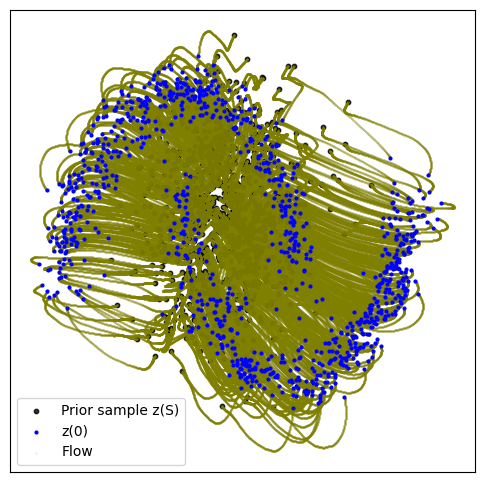

In [16]:
traj = torch.stack(trajectory).cpu().detach().numpy()
plot_limit = 1024

plt.figure(figsize=(6, 6))

# Plot the first time point in black
plt.scatter(traj[0, :plot_limit, 0], traj[0, :plot_limit, 1], s=10, alpha=0.8, c="black", label='Prior sample z(S)')

# Plot all the rest of the time points except the first and last in olive
for i in range(1, traj.shape[0]-1):
    plt.scatter(traj[i, :plot_limit, 0], traj[i, :plot_limit, 1], s=0.2, alpha=0.2, c="olive")

# Plot the last time point in blue
plt.scatter(traj[-1, :plot_limit, 0], traj[-1, :plot_limit, 1], s=4, alpha=1, c="blue", label='z(0)')

# Add a second legend for "Flow" since we can't label in the loop directly
plt.scatter([], [], s=0.2, alpha=0.2, c="olive", label='Flow')
plt.legend()
plt.xticks([])
plt.yticks([])
plt.show()

# What happens when you sample from an untrained model with DDPM

/home/dreidenbach/mambaforge/envs/moco_bionemo/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


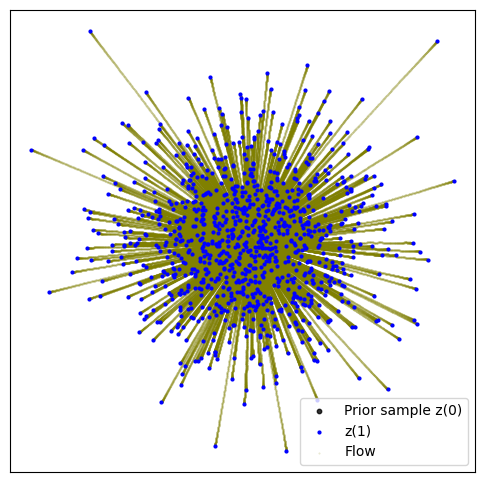

In [18]:
with torch.no_grad():
    model = Network(dim_in=dim, 
                dim_out=dim, 
                dim_hids=[hidden_size]*num_hiddens).to(DEVICE)
    inf_size = 1024
    sample = ddpm.sample_prior((inf_size, 2)).to(DEVICE)
    trajectory2 = [sample.cpu()]
    for t in schedule:
        full_t  = torch.full((inf_size,), t).to(DEVICE)
        vt = model(sample, full_t) # calculate the vector field based on the definition of the model
        sample = ddpm.step_noise(vt, full_t, sample)
        trajectory2.append(sample.cpu()) #
plot_limit = 1024
traj = torch.stack(trajectory2).cpu().detach().numpy()

plt.figure(figsize=(6, 6))

# Plot the first time point in black
plt.scatter(traj[0, :plot_limit, 0], traj[0, :plot_limit, 1], s=10, alpha=0.8, c="black", label='Prior sample z(0)')

# Plot all the rest of the time points except the first and last in olive
for i in range(1, traj.shape[0]-1):
    plt.scatter(traj[i, :plot_limit, 0], traj[i, :plot_limit, 1], s=0.2, alpha=0.2, c="olive")

# Plot the last time point in blue
plt.scatter(traj[-1, :plot_limit, 0], traj[-1, :plot_limit, 1], s=4, alpha=1, c="blue", label='z(1)')

# Add a second legend for "Flow" since we can't label in the loop directly
plt.scatter([], [], s=0.2, alpha=0.2, c="olive", label='Flow')
plt.legend()
plt.xticks([])
plt.yticks([])
plt.show()

# Now let's switch the parameterization of DDPM from noise to data

Here instead of training the model to learn the noise we want to learn the raw data. Both options are valid and the choice of which depends on the underlying modeling task.

In [19]:
from bionemo.moco.distributions.time.uniform import UniformTimeDistribution
from bionemo.moco.interpolants.discrete_time.continuous.ddpm import DDPM
from bionemo.moco.schedules.noise.discrete_noise_schedules import DiscreteCosineNoiseSchedule, DiscreteLinearNoiseSchedule
from bionemo.moco.schedules.inference_time_schedules import DiscreteLinearInferenceSchedule
from bionemo.moco.distributions.prior.continuous.gaussian import GaussianPrior
DEVICE = "cuda:0"
uniform_time = UniformTimeDistribution(discrete_time=True, nsteps = 1000)
simple_prior = GaussianPrior()
ddpm = DDPM(time_distribution=uniform_time, 
                            prior_distribution=simple_prior,
                            prediction_type = "data",
                            noise_schedule = DiscreteLinearNoiseSchedule(nsteps = 1000),
                            device=DEVICE)

## Let us first train the model with a weight such that it is theoretically equivalent to the simple noise matching loss. See Equation 9 from https://arxiv.org/pdf/2202.00512

In [20]:
# Place both the model and the interpolant on the same device
dim = 2
hidden_size = 128
num_hiddens = 3
batch_size = 256
model = Network(dim_in=dim, 
                dim_out=dim, 
                dim_hids=[hidden_size]*num_hiddens)
optimizer = torch.optim.Adam(model.parameters(), lr = 1.e-3)
DEVICE = "cuda"
model = model.to(DEVICE)
ddpm = ddpm.to_device(DEVICE)
for k in range(20000):
    optimizer.zero_grad()
    shape = (batch_size, dim)
    x0 = ddpm.sample_prior(shape).to(DEVICE)
    x1 = sample_moons(batch_size).to(DEVICE)

    t = ddpm.sample_time(batch_size)
    xt = ddpm.interpolate(x1, t, x0)

    x_hat = model(xt, t)
    loss = ddpm.loss(x_hat, x1, t, weight_type="data_to_noise").mean()

    loss.backward()
    optimizer.step()

    if (k + 1) % 1000 == 0:
        print(f"{k+1}: loss {loss.item():0.3f}") 

1000: loss 9.059
2000: loss 0.454
3000: loss 0.937
4000: loss 0.405
5000: loss 6.261
6000: loss 0.595
7000: loss 0.431
8000: loss 0.346
9000: loss 0.375
10000: loss 0.541
11000: loss 4.093
12000: loss 0.407
13000: loss 0.649
14000: loss 4.216
15000: loss 0.325
16000: loss 0.438
17000: loss 1.446
18000: loss 4.675
19000: loss 0.403
20000: loss 0.470


In [23]:
with torch.no_grad():
    inf_size = 1024
    sample = ddpm.sample_prior((inf_size, 2)).to(DEVICE) # Start with noise
    trajectory = [sample.cpu()]
    for t in schedule:
        full_t  = torch.full((inf_size,), t).to(DEVICE)
        x_hat = model(sample, full_t) # calculate the vector field based on the definition of the model
        sample = ddpm.step(x_hat, full_t, sample)
        trajectory.append(sample.cpu()) # save the trajectory for plotting purposes


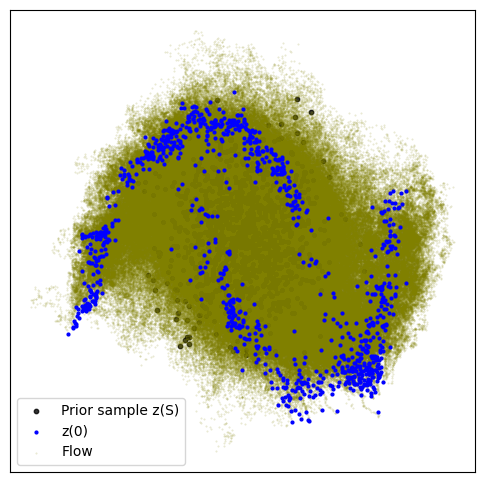

In [24]:
import matplotlib.pyplot as plt
traj = torch.stack(trajectory).cpu().detach().numpy()
plot_limit = 1024

plt.figure(figsize=(6, 6))

# Plot the first time point in black
plt.scatter(traj[0, :plot_limit, 0], traj[0, :plot_limit, 1], s=10, alpha=0.8, c="black", label='Prior sample z(S)')

# Plot all the rest of the time points except the first and last in olive
for i in range(1, traj.shape[0]-1):
    plt.scatter(traj[i, :plot_limit, 0], traj[i, :plot_limit, 1], s=0.2, alpha=0.2, c="olive")

# Plot the last time point in blue
plt.scatter(traj[-1, :plot_limit, 0], traj[-1, :plot_limit, 1], s=4, alpha=1, c="blue", label='z(0)')

# Add a second legend for "Flow" since we can't label in the loop directly
plt.scatter([], [], s=0.2, alpha=0.2, c="olive", label='Flow')
plt.legend()
plt.xticks([])
plt.yticks([])
plt.show()

## Now let us train with no loss weighting to optimize a true data matching loss for comparison

In [25]:
# Place both the model and the interpolant on the same device
dim = 2
hidden_size = 128
num_hiddens = 3
batch_size = 256
model = Network(dim_in=dim, 
                dim_out=dim, 
                dim_hids=[hidden_size]*num_hiddens)
optimizer = torch.optim.Adam(model.parameters(), lr = 1.e-3)
DEVICE = "cuda"
model = model.to(DEVICE)
ddpm = ddpm.to_device(DEVICE)
for k in range(20000):
    optimizer.zero_grad()
    shape = (batch_size, dim)
    x0 = ddpm.sample_prior(shape).to(DEVICE)
    x1 = sample_moons(batch_size).to(DEVICE)

    t = ddpm.sample_time(batch_size)
    xt = ddpm.interpolate(x1, t, x0)

    x_hat = model(xt, t)
    loss = ddpm.loss(x_hat, x1, t, weight_type="ones").mean()

    loss.backward()
    optimizer.step()

    if (k + 1) % 1000 == 0:
        print(f"{k+1}: loss {loss.item():0.3f}") 

1000: loss 2.738
2000: loss 2.683
3000: loss 2.559
4000: loss 2.717
5000: loss 2.514
6000: loss 2.676
7000: loss 2.553
8000: loss 3.106
9000: loss 2.912
10000: loss 2.505
11000: loss 2.695
12000: loss 2.231
13000: loss 2.603
14000: loss 2.855
15000: loss 2.672
16000: loss 2.814
17000: loss 2.620
18000: loss 2.849
19000: loss 2.471
20000: loss 2.488


In [26]:
with torch.no_grad():
    inf_size = 1024
    sample = ddpm.sample_prior((inf_size, 2)).to(DEVICE) # Start with noise
    trajectory = [sample.cpu()]
    for t in schedule:
        full_t  = torch.full((inf_size,), t).to(DEVICE)
        x_hat = model(sample, full_t) # calculate the vector field based on the definition of the model
        sample = ddpm.step(x_hat, full_t, sample)
        trajectory.append(sample.cpu()) # save the trajectory for plotting purposes


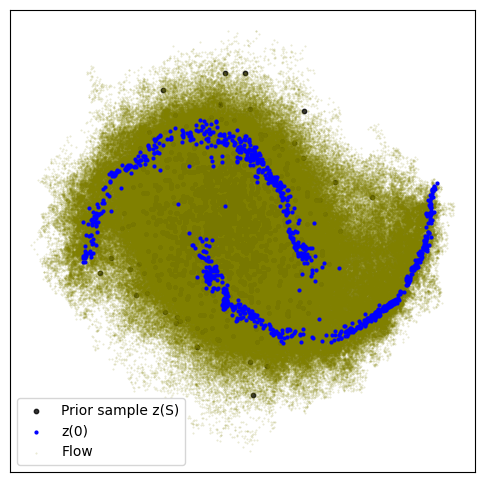

In [27]:
import matplotlib.pyplot as plt
traj = torch.stack(trajectory).cpu().detach().numpy()
plot_limit = 1024

plt.figure(figsize=(6, 6))

# Plot the first time point in black
plt.scatter(traj[0, :plot_limit, 0], traj[0, :plot_limit, 1], s=10, alpha=0.8, c="black", label='Prior sample z(S)')

# Plot all the rest of the time points except the first and last in olive
for i in range(1, traj.shape[0]-1):
    plt.scatter(traj[i, :plot_limit, 0], traj[i, :plot_limit, 1], s=0.2, alpha=0.2, c="olive")

# Plot the last time point in blue
plt.scatter(traj[-1, :plot_limit, 0], traj[-1, :plot_limit, 1], s=4, alpha=1, c="blue", label='z(0)')

# Add a second legend for "Flow" since we can't label in the loop directly
plt.scatter([], [], s=0.2, alpha=0.2, c="olive", label='Flow')
plt.legend()
plt.xticks([])
plt.yticks([])
plt.show()

### The choice in data vs noise and variance schedule are hyperparameters that must be tuned to each task

### many of these choices are empirical and part of the tuning process to best model your data via noise, data, or even velocity prediction.